### Packages

In [31]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

## Assignment 3, Part 1: Data Exploration. 
Load the titanic dataset from Seaborn by using the load_dataset(‘titanic’) method. Document the columns that are missing data both numerically (via a count) and visually (via an sns heatmap). Document which values are categorical. Explore the data and answer the following questions: Did more women or men die on the Titanic? Which passenger class was more likely to survive? What does the distribution of fare look like? What does the distribution of non-null age values look like? What is the median age of each passenger class (pclass)? Visualize this in a box plot.

In [3]:
# Load the titanic dataset from Seaborn by using the load_dataset(‘titanic’) method.
titanic_DF = pd.read_csv('titanic_train.csv')

titanic_DF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Document the columns that are missing data both numerically (via a count) and visually (via an sns heatmap). 
titanicMissing = titanic_DF.isna().sum()
print(titanicMissing)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


<AxesSubplot:>

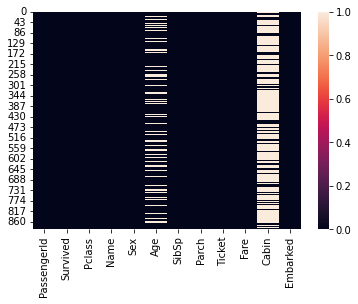

In [5]:
# Document the columns that are missing data both numerically (via a count) and visually (via an sns heatmap). 
sns.heatmap(titanic_DF.isnull())

In [6]:
# Document which values are categorical.
cat_features=[i for i in titanic_DF.columns if titanic_DF.dtypes[i]=='object']
print(cat_features)

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']


In [7]:
# Did more women or men die on the Titanic? 0 = dead, 1 = alive
pd.crosstab(titanic_DF['Survived'],titanic_DF['Sex'])

Sex,female,male
Survived,,
0,81,468
1,233,109


Based on the above table, more men died on the Titanic than women.

In [8]:
# Which passenger class was more likely to survive? (0 = dead, 1 = alive) (1 = 1st class, 2 = 2nd class, 3 = 3rd class)
pd.crosstab(titanic_DF['Survived'],titanic_DF['Pclass'])

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


Based on the above calculation, more 1st class passengers survived than 2nd or 3rd class. 3rd class passengers had the highest number that died on the titanic.

<AxesSubplot:xlabel='Fare', ylabel='Count'>

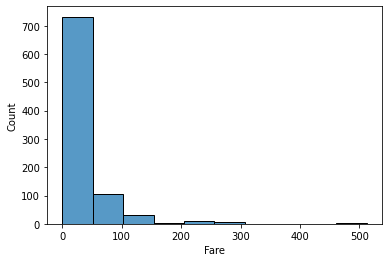

In [9]:
# What does the distribution of fare look like?
sns.histplot(titanic_DF, x="Fare", bins = 10)

<AxesSubplot:xlabel='Age', ylabel='Count'>

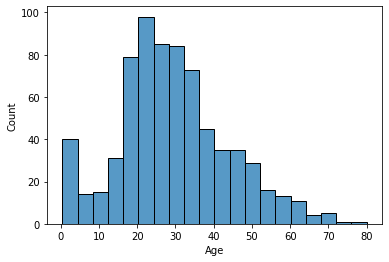

In [10]:
# What does the distribution of non-null age values look like?
sns.histplot(titanic_DF, x="Age")

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64


<AxesSubplot:xlabel='Pclass', ylabel='Age'>

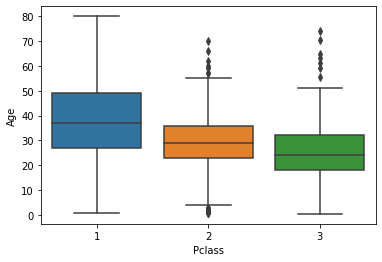

In [11]:
# What is the median age of each passenger class (pclass)? Visualize this in a box plot.

#Calculation
medians = titanic_DF.groupby(['Pclass'])['Age'].median()
print(medians)

#Visulization
box_plot = sns.boxplot(x = "Pclass", y = "Age", data = titanic_DF)
box_plot

### Assignment 3, Part 2: Data Cleansing. 
Since there are so many missing values in Cabin, get rid of the cabin feature. Define a function to impute age using the
median of the passenger class you computed earlier. To call it, use train[[‘age’,‘pclass]].apply(impute_age,axis=1). Drop the remaining records containing null values. Show there are no remaining null values. Convert categorical variables to numeric dummies using pandas’ get_dummies() method. Add these to your training dataframe. Drop the categorical columns you converted earlier as well as name, ticket, and passengerId. Create a feature set by dropping “Survived.” Your resulting feature set should include pclass, age, sibsp, parch, fare, and the categorical dummy columns you created earlier. Implement a label dataframe by
copying the contents of the Survived column of your training set to a new dataframe. Split your clean data into a training and test set.

In [12]:
# Since there are so many missing values in Cabin, get rid of the cabin feature.
titanic_DF = titanic_DF.drop(columns = ['Cabin'])

titanic_DF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [13]:
# Define a function to impute age using the median of the passenger class you computed earlier. 
# To call it, use train[[‘age’,‘pclass]].apply(impute_age,axis=1).

def impute_age(columns):
    Age = columns[0]
    Pclass = columns[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        elif Pclass == 3:
            return 24
    else:
        return Age

titanic_DF['Age'] = titanic_DF[['Age','Pclass']].apply(impute_age,axis=1)

titanic_DF

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [14]:
# Check again for null values
titanic_DF.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [15]:
# Drop the remaining records containing null values.
titanic_DF = titanic_DF[titanic_DF['Embarked'].notna()]

titanic_DF

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [16]:
# Show there are no remaining null values. 
titanic_DF.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [17]:
# Convert categorical variables to numeric dummies using pandas’ get_dummies() method. Add these to your training dataframe.
titanic_DF = pd.get_dummies(titanic_DF, columns=['Sex', 'Embarked'])

titanic_DF

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,0,1,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,1,0,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",24.0,1,2,W./C. 6607,23.4500,1,0,0,0,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,0,1,1,0,0


In [18]:
# Drop the categorical columns you converted earlier as well as name, ticket, and passengerId. 
titanic_DF = titanic_DF.drop(columns = ['PassengerId',  'Ticket', 'Name'])

titanic_DF

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,1,19.0,0,0,30.0000,1,0,0,0,1
888,0,3,24.0,1,2,23.4500,1,0,0,0,1
889,1,1,26.0,0,0,30.0000,0,1,1,0,0


In [19]:
# Create a feature set by dropping “Survived.” Your resulting feature set should include pclass, age, sibsp, parch, fare, 
# and the categorical dummy columns you created earlier. 
titanic_DF_features = titanic_DF.drop(columns = ['Survived'])

titanic_DF_features

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
886,2,27.0,0,0,13.0000,0,1,0,0,1
887,1,19.0,0,0,30.0000,1,0,0,0,1
888,3,24.0,1,2,23.4500,1,0,0,0,1
889,1,26.0,0,0,30.0000,0,1,1,0,0


In [20]:
# Implement a label dataframe by copying the contents of the Survived column of your training set to a new dataframe. 
titanic_DF_label = titanic_DF['Survived']

titanic_DF_label

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

In [21]:
# Split your clean data into a training and test set.
features_train, features_test, labels_train, labels_test = train_test_split(titanic_DF_features, titanic_DF_label, 
                                                                            test_size=0.2)
print("Sizes of training and test sets:", [len(elem) for elem in [features_train, features_test, labels_train, labels_test]])

Sizes of training and test sets: [711, 178, 711, 178]


### Assignment 3, Part 3: Model Training. 
Implement a logistic regression model. Implement a support vector classifier. Implement an sgd classifier. Print out the
classification reports, confusion matrices, and roc score and chart for each of these. Remember to set Probability=True for SVM and use method=decision_function in a cross_val_predict instead of predict_proba for the SGD ROC plot.

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       435
           1       0.77      0.71      0.74       276

    accuracy                           0.81       711
   macro avg       0.80      0.79      0.79       711
weighted avg       0.80      0.81      0.80       711

ROC Score: 0.78774


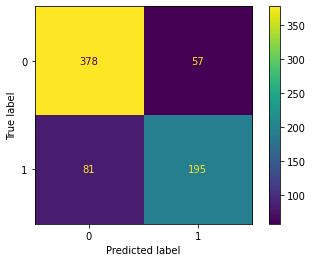

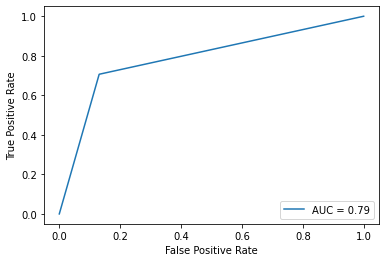

In [22]:
# Implement a logistic regression model. Print out the classification reports, confusion matrices, and roc score and chart.
lr = LogisticRegression(solver="liblinear", random_state=99)
lr.fit(features_train, labels_train.values.ravel())
lr_preds = lr.predict(features_train)

print(classification_report(labels_train, lr_preds))

conf1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_train, lr_preds, labels=lr.classes_), 
                               display_labels=lr.classes_).plot()

fpr, tpr, thresholds = roc_curve(labels_train, lr_preds)
roc_auc = auc(fpr, tpr)
print("ROC Score: {}".format(round(roc_auc, 5)))

roc1 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

              precision    recall  f1-score   support

           0       0.85      0.52      0.65       435
           1       0.53      0.86      0.66       276

    accuracy                           0.65       711
   macro avg       0.69      0.69      0.65       711
weighted avg       0.73      0.65      0.65       711

ROC Score: 0.69142


/mnt/c/users/rainb/desktop/scripts/COMP4447/dst1_env/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


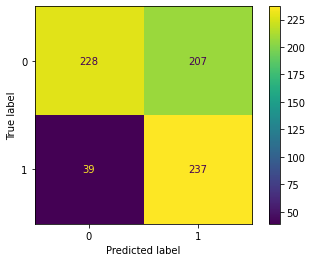

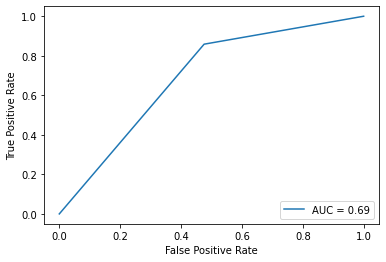

In [23]:
# Implement a support vector classifier. Print out the classification reports, confusion matrices, and roc score and chart.
svm = LinearSVC(C=1, loss="hinge", random_state=99)
svm.fit(features_train, labels_train.values.ravel())
svm_preds = svm.predict(features_train)

print(classification_report(labels_train, svm_preds))

conf2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_train, svm_preds, labels=svm.classes_),
                      display_labels=svm.classes_).plot()

fpr, tpr, thresholds = roc_curve(labels_train, svm_preds)
roc_auc = auc(fpr, tpr)
print("ROC Score: {}".format(round(roc_auc, 5)))

roc2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       435
           1       0.72      0.78      0.75       276

    accuracy                           0.79       711
   macro avg       0.78      0.79      0.79       711
weighted avg       0.80      0.79      0.80       711

ROC Score: 0.79113


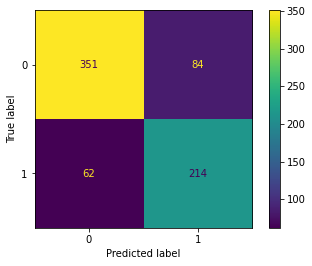

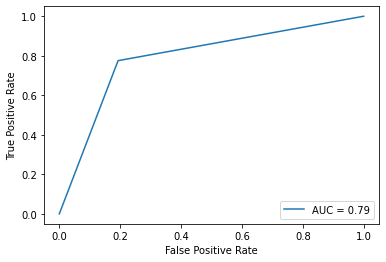

In [24]:
# Implement an sgd classifier. Print out the classification reports, confusion matrices, and roc score and chart.

sgd = SGDClassifier(random_state=99)
sgd.fit(features_train, labels_train.values.ravel())
sgd_preds = sgd.predict(features_train)

print(classification_report(labels_train, sgd_preds))

conf3 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_train, sgd_preds, labels=sgd.classes_),
                      display_labels=sgd.classes_).plot()

fpr, tpr, thresholds = roc_curve(labels_train, sgd_preds)
roc_auc = auc(fpr, tpr)
print("ROC Score: {}".format(round(roc_auc, 5)))

roc3 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

### Assignment 3, Part 4: Model Tuning
- See if scaling your input data affects your SVC model (implement a sklearn pipeline to combine scaling and instantiation of your model).
- Do a grid search of your pipeline classifier using the following parameter
    - grid: {‘<your_svc_model_name>__kernel’: [‘rbf’],
    - ‘<your_svc_model_name> __gamma’: [0.0001, 0.001, 0.01, 0.1, 1],
    - ‘{‘<your_svc_model_name>__C’: [1,10,50,100,200,300]}.
- Print the best estimator, its parameters, and the resulting score. Apply this estimator to your test set
- Implement a learning curve using your best estimator from the gridsearch.
    - The figure should have a title of “learning curve.”
    - Label the y-axis with “Score.” 
    - Label the x-axis with “Training Examples.” 
    - Make the training score red. 
    - Make the validation score green. -
    - What does this learning curve tell you?

ROC Score: 0.83986


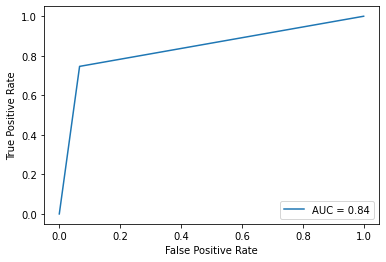

In [25]:
# See if scaling your input data affects your SVC model (implement a sklearn pipeline to combine scaling and instantiation 
# of your model).

svc_scaled = Pipeline([("scaler", StandardScaler()),("poly_svc", SVC(kernel="poly", degree=3, coef0=1, C=5, random_state=99))])
svc_scaled.fit(features_train, labels_train.values.ravel())
svc_scaled_preds = svc_scaled.predict(features_train)

fpr, tpr, thresholds = roc_curve(labels_train, svc_scaled_preds)
roc_auc = auc(fpr, tpr)
print("ROC Score: {}".format(round(roc_auc, 5)))
scaleddisplayROC = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [26]:
# Do a grid search of your pipeline classifier using the following parameter
# grid: {‘<your_svc_model_name>__kernel’: [‘rbf’],
# ‘<your_svc_model_name> __gamma’: [0.0001, 0.001, 0.01, 0.1, 1],
# ‘{‘<your_svc_model_name>__C’: [1,10,50,100,200,300]}.

param_grid =  {'poly_svc__kernel': ['rbf'], 'poly_svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'poly_svc__C': [1,10,50,100,200,300]}
grid_search = GridSearchCV(svc_scaled, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(features_train, labels_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly_svc',
                                        SVC(C=5, coef0=1, kernel='poly',
                                            random_state=99))]),
             param_grid={'poly_svc__C': [1, 10, 50, 100, 200, 300],
                         'poly_svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'poly_svc__kernel': ['rbf']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [27]:
# Print the best estimator, its parameters, and the resulting score. 
print('Best Estimator:')
print(grid_search.best_estimator_)

print('\nParameters:')
print(grid_search.best_estimator_.get_params())

fpr, tpr, thresholds = roc_curve(labels_train, grid_search.best_estimator_.predict(features_train))
roc_auc = auc(fpr, tpr)
print('\nResulting Score: {}'.format(round(roc_auc, 5)))

Best Estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('poly_svc', SVC(C=10, coef0=1, gamma=0.1, random_state=99))])

Parameters:
{'memory': None, 'steps': [('scaler', StandardScaler()), ('poly_svc', SVC(C=10, coef0=1, gamma=0.1, random_state=99))], 'verbose': False, 'scaler': StandardScaler(), 'poly_svc': SVC(C=10, coef0=1, gamma=0.1, random_state=99), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'poly_svc__C': 10, 'poly_svc__break_ties': False, 'poly_svc__cache_size': 200, 'poly_svc__class_weight': None, 'poly_svc__coef0': 1, 'poly_svc__decision_function_shape': 'ovr', 'poly_svc__degree': 3, 'poly_svc__gamma': 0.1, 'poly_svc__kernel': 'rbf', 'poly_svc__max_iter': -1, 'poly_svc__probability': False, 'poly_svc__random_state': 99, 'poly_svc__shrinking': True, 'poly_svc__tol': 0.001, 'poly_svc__verbose': False}

Resulting Score: 0.84229


              precision    recall  f1-score   support

           0       0.86      0.95      0.90       114
           1       0.89      0.73      0.80        64

    accuracy                           0.87       178
   macro avg       0.88      0.84      0.85       178
weighted avg       0.87      0.87      0.87       178

ROC Score: 0.84087


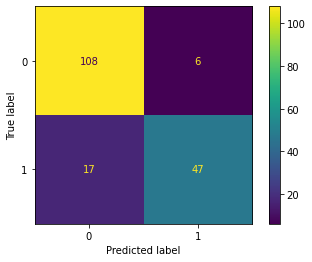

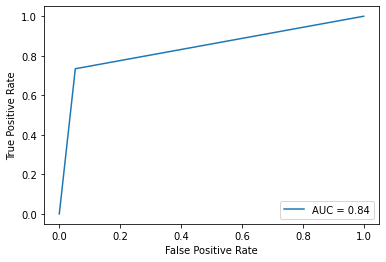

In [28]:
#Apply this estimator to your test set

final = grid_search.best_estimator_
final.fit(features_test, labels_test.values.ravel())
final_preds = final.predict(features_test)

print(classification_report(labels_test, final_preds))

conf_final = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(labels_test, final_preds, labels=final.classes_),
                      display_labels=final.classes_).plot()

fpr, tpr, thresholds = roc_curve(labels_test, final_preds)
roc_auc = auc(fpr, tpr)
print("ROC Score: {}".format(round(roc_auc, 5)))

roc_final = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [34]:
# Implement a learning curve using your best estimator from the gridsearch.
train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, features_test, labels_test, cv=10, 
                                                        scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))